# Decision trees

Noter til diskussion
- skal vi lave en train split, så vi i bunden også kan vise hvor god træet er til at forudsige?
- prøv lejlighed eller hus ud fra dør (TV, TH)
- slå koderne sammen - lav en True/False efter hvilken type vi kører, BDT eller NN
- lav function til at plotte så den kun kører en gang

In [1]:
# Importer pakker der skal bruges
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import pandas as pd

## Inspicer dataen

In [2]:
# importer data fra csv-fil (excel)
data = pd.read_csv('HousingPrices_selected.csv', sep=',')

# print første 5 rækker data
print(data.head(5))

   Postnummer  Husnummer  kvadratmeter  Grundareal  Byggeår  afstand_skole  \
0      4953.0        9.0            97       949.0   1942.0        5425.42   
1      2300.0       12.0            86         0.0   2006.0        1045.23   
2      2300.0       12.0            86         0.0   2006.0        1045.23   
3      2300.0       16.0            95         0.0   2007.0        1017.53   
4      2300.0       18.0            73         0.0   2007.0        1004.49   

   afstand_supermarked  Salgspris  
0              5551.78    1050000  
1               132.97    1352500  
2               132.97    3500000  
3               153.93    3463432  
4               166.23    2700000  


## Parameter

In [5]:
forudsig = 'Salgspris' # Hvilken parameter vi gerne vil forudsige i vores data
DT_N_lag = 3                # Hvor mange lag der er i træet

Max dybde af træet: 3


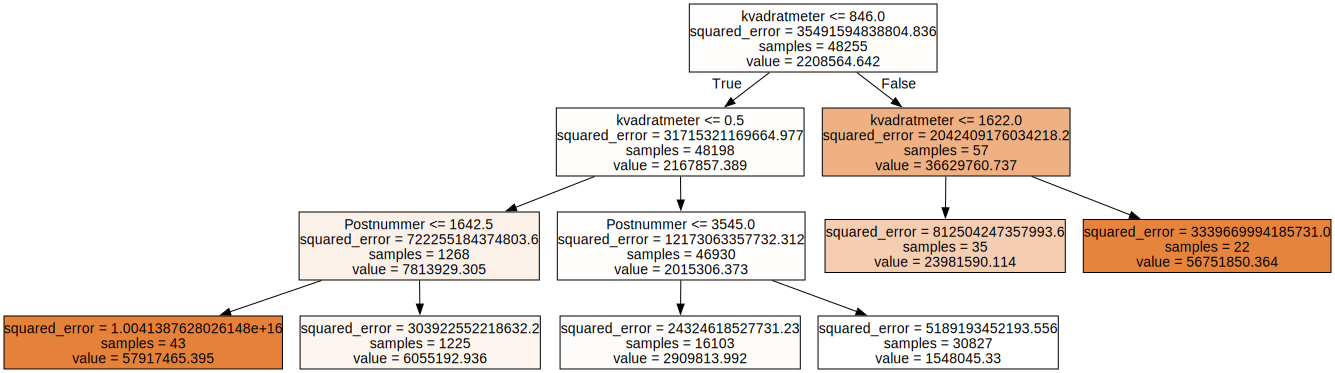

In [6]:
# Deler dataen op i det vi gerne vil lære at forudsige (truth_data) og resten (input_data)
variabler       = data.columns
input_variabler = variabler[(variabler != forudsig)]
input_data      = data[input_variabler]
truth_data      = data[forudsig]

X = input_data #fjern
y = truth_data

# Navn på parametre
labels = input_data.columns

# Her bliver modellen trænet på data
estimator = DecisionTreeRegressor(
   max_depth=DT_N_lag,                        # Hvor mange lag der højest må være - Hvor mange spørgsmål må der stilles ud af en gren
   min_samples_leaf = 20,
   random_state=42                       # Gør at vi får det samme "tilfældige" træ hver gang
   )
estimator.fit(X, y)   # Dette er den "magiske" linje - her optimerer Machine Learning algoritmen sine interne vægte til at give bedste svar

# laver visuel graf af træet
graph = Source(tree.export_graphviz(estimator, out_file=None,
   feature_names=labels,              # Labels bliver brugt som overskrifter
   filled=True,                       # Farver noder efter pris - højere pris, mørkere farve
   max_depth=3))                      # Hvor mange lag den skal vise i grafen

print("Max dybde af træet:", estimator.get_depth()) 
display(SVG(graph.pipe(format='svg')))


### Ideer til at lege rundt med koden

- Inspicer træet. Forstår du/I, hvad de forskellige tal betyder?
  Hvilken type bolig passer flest eksempler ned i, i lag 2? Hvad er algoritmens bud på deres pris (dvs. gennemsnitsprisen)?
- Prøv at ændre på hvor mange lag der er i træet fra 2 til 3.
  Hvilken parameter bliver brugt oftest til at opdele data? Tror du/I at den så er den vigtigste parameter?
  Kan du/I ud fra træet sige mere generelt hvilke parametre der betyder mest for prisen? Hvilke betyder mindst?
- Prøv at træne træet på en anden parameter ved at ændre "forudsig" - Er nogen parameter nemmere at forudsige end andre? Hvorfor?